In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [22]:
Image_Size = 256
Batch_Size = 32
channels = 3
Epochs = 85
input_shape = (Batch_Size,Image_Size,Image_Size,channels)

In [23]:
df = tf.keras.preprocessing.image_dataset_from_directory(
    "metal_nut/test/",
    shuffle = True,
    image_size = (Image_Size,Image_Size),
    batch_size = Batch_Size
)

Found 471 files belonging to 5 classes.


In [24]:
class_names = df.class_names
class_names = [class_name for class_name in class_names if class_name != '.ipynb_checkpoints']

class_names

['bent', 'color', 'flip', 'good', 'scratch']

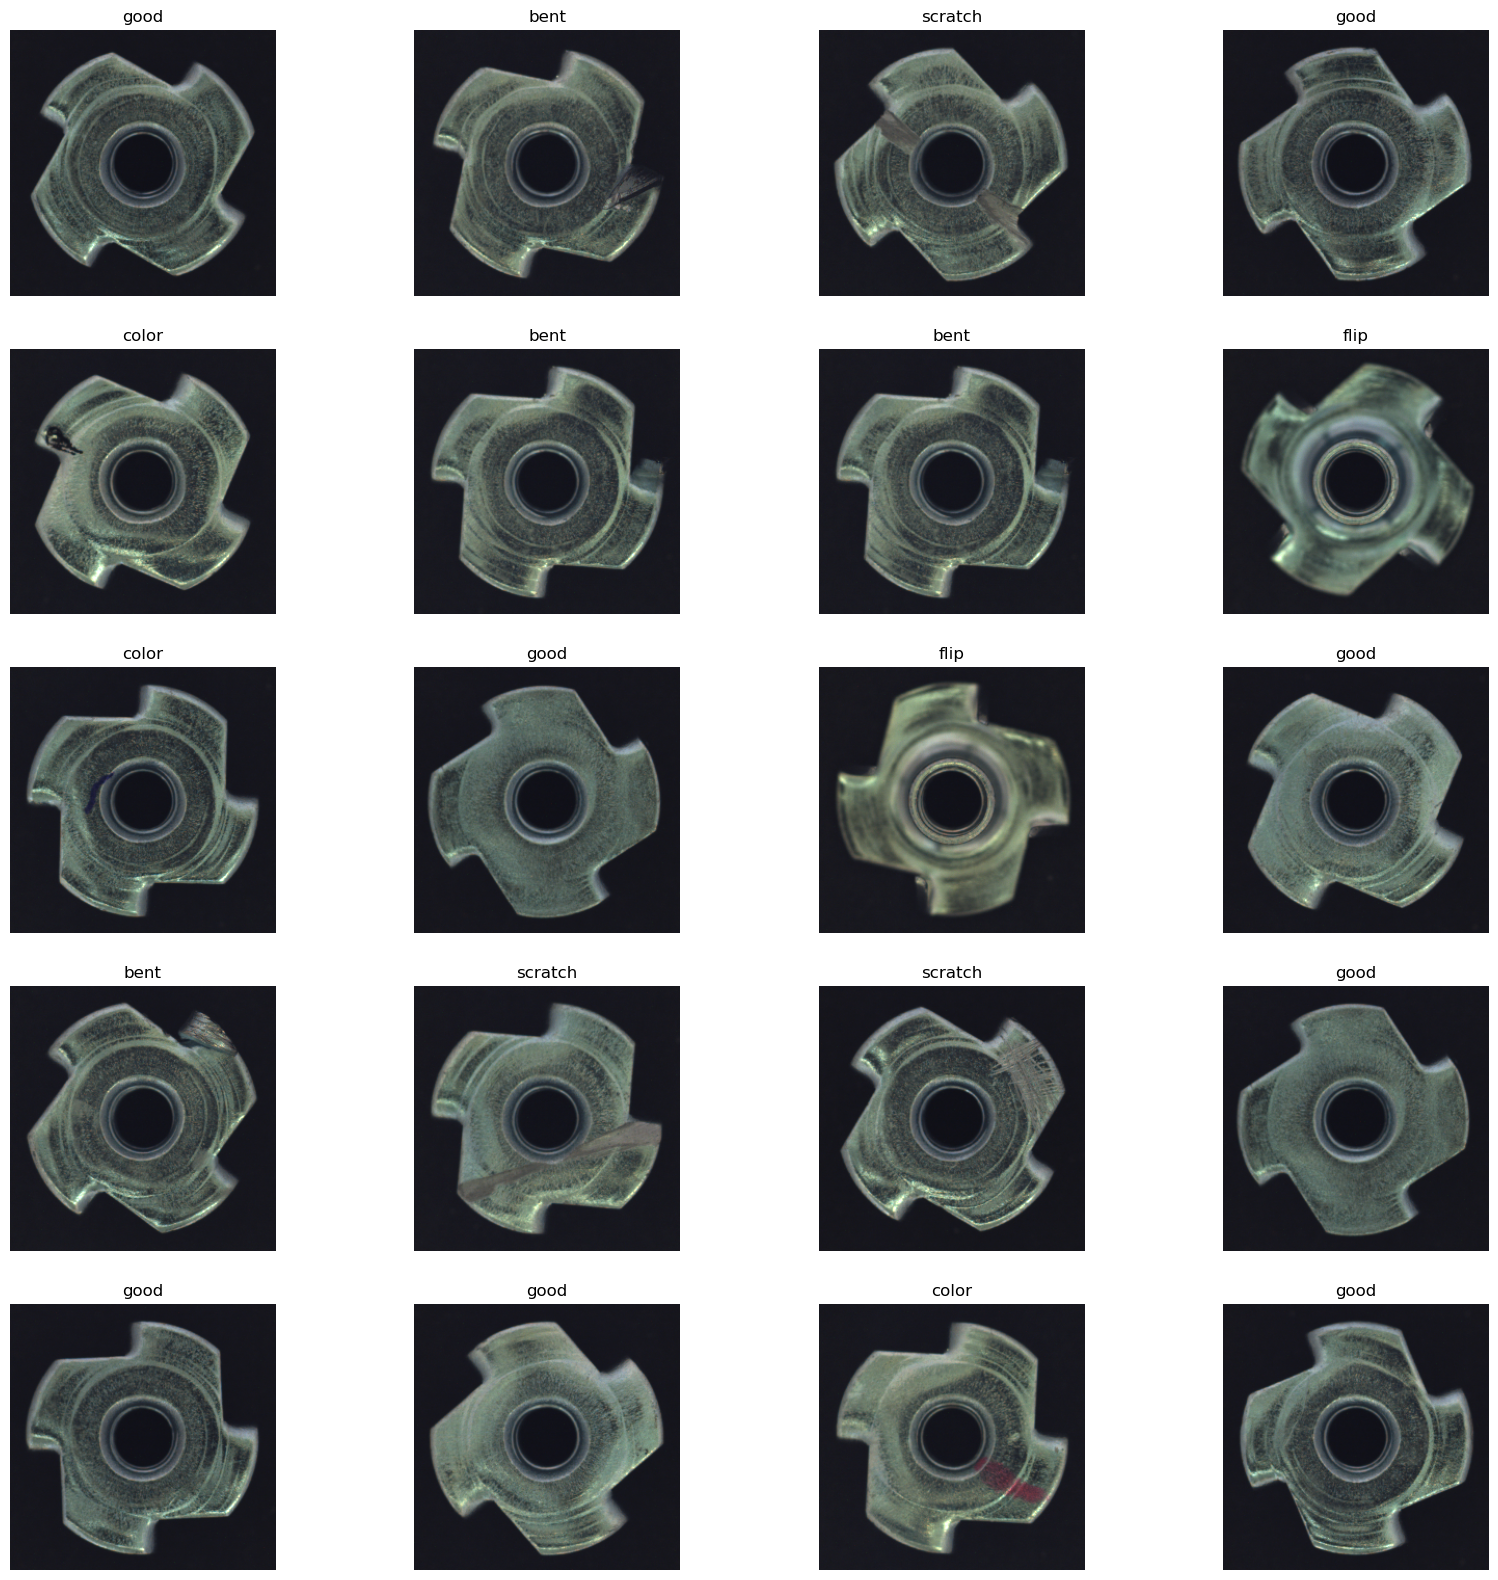

In [25]:
plt.figure(figsize=(20,20))
for image, label in df.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")
#     print(image.shape)
#     print(label.numpy())

In [26]:
def get_part(df, tr_s = 0.8, te_s = 0.1, v_s = 0.1, shuffle = True, s_size = 1000):
    df_size = len(df)

    if shuffle:
        df = df.shuffle(s_size, seed = 12)

    train_size = int(tr_s * df_size)
    val_size = int(v_s * df_size)

    train_ds = df.take(train_size)

    val_ds = df.skip(train_size).take(val_size)
    test_ds = df.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [27]:
train_ds, val_ds, test_ds = get_part(df)

In [28]:
len(train_ds)

12

In [29]:
len(test_ds)

2

In [30]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [31]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1.0/255),
])


In [32]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.2)
])

In [33]:
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation = 'softmax')
])

model.build(input_shape= input_shape)

In [34]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [35]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = 'accuracy')

In [36]:
history = model.fit(train_ds,
                   epochs=Epochs,
                   batch_size=Batch_Size,
                   verbose=1,
                   validation_data=val_ds)

Epoch 1/85
12/12 [==============================] - 5s 318ms/step - loss: 1.7279 - accuracy: 0.2560 - val_loss: 1.6646 - val_accuracy: 0.1875
Epoch 2/85
12/12 [==============================] - 3s 214ms/step - loss: 1.5749 - accuracy: 0.2907 - val_loss: 1.6116 - val_accuracy: 0.2188
Epoch 3/85
12/12 [==============================] - 3s 221ms/step - loss: 1.5658 - accuracy: 0.3013 - val_loss: 1.5911 - val_accuracy: 0.2188
Epoch 4/85
12/12 [==============================] - 3s 216ms/step - loss: 1.5073 - accuracy: 0.3333 - val_loss: 1.5600 - val_accuracy: 0.3438
Epoch 5/85
12/12 [==============================] - 2s 202ms/step - loss: 1.3560 - accuracy: 0.3947 - val_loss: 1.3365 - val_accuracy: 0.3438
Epoch 6/85
12/12 [==============================] - 2s 202ms/step - loss: 1.3914 - accuracy: 0.3680 - val_loss: 1.4303 - val_accuracy: 0.2812
Epoch 7/85
12/12 [==============================] - 2s 207ms/step - loss: 1.2732 - accuracy: 0.4320 - val_loss: 1.3134 - val_accuracy: 0.3438
Epoch 

In [37]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 1s 46ms/step - loss: 0.3293 - accuracy: 0.8594


In [38]:
scores

[0.3293016850948334, 0.859375]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

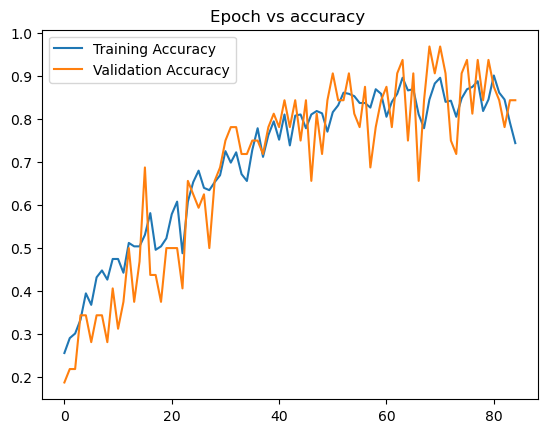

In [40]:
plt.plot(range(Epochs), acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.title("Epoch vs accuracy ")
plt.legend()

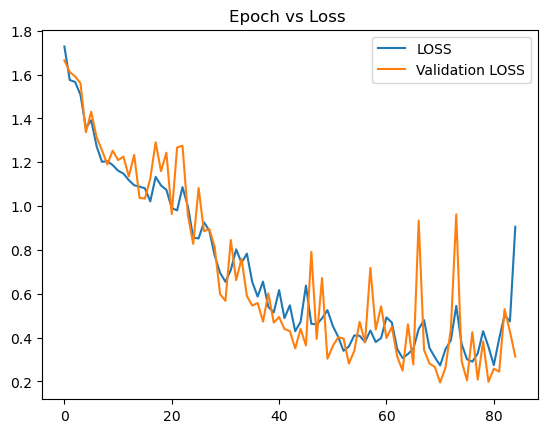

In [41]:
plt.plot(range(Epochs), loss, label = "LOSS")
plt.plot(range(Epochs), val_loss, label = "Validation LOSS")
plt.title("Epoch vs Loss ")
plt.legend()

First Image
Actual Label:  flip
1/1 [==============================] - 0s 29ms/step
flip


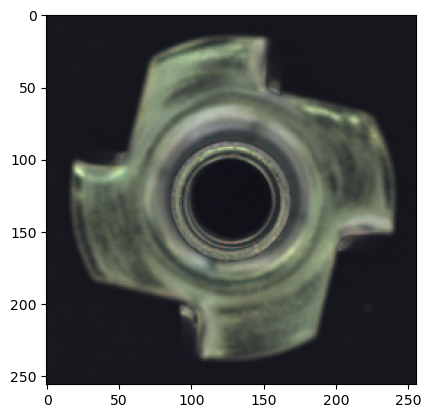

In [49]:
for images_batch, label_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    
    print("First Image")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    
    batch_pred = model.predict(images_batch)
    print(class_names[np.argmax(batch_pred[0])])